In [22]:
# libraries
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from tqdm import tqdm

matplotlib.rcParams['figure.figsize'] = [18, 12]

# code from this library - import the lines module
import loss_landscapes
import loss_landscapes.metrics

In [23]:
# training hyperparameters
IN_DIM = 784
OUT_DIM = 10
LR = 10 ** -2
BATCH_SIZE = 512
EPOCHS = 25
# contour plot resolution
STEPS = 100

In [24]:
class ten_hidden(torch.nn.Module):
    """ Fully connected feed-forward neural network with one hidden layer. """
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.linear_1 = torch.nn.Linear(x_dim, 23)
        self.linear_2 = torch.nn.Linear(23, 23)
        self.linear_3 = torch.nn.Linear(23, 23)
        self.linear_4 = torch.nn.Linear(23, 23)
        self.linear_5 = torch.nn.Linear(23, 23)
        self.linear_6 = torch.nn.Linear(23, 23)
        self.linear_7 = torch.nn.Linear(23, 23)
        self.linear_8 = torch.nn.Linear(23, 23)
        self.linear_9 = torch.nn.Linear(23, 23)
        self.linear_10 = torch.nn.Linear(23, 23)
        self.linear_11 = torch.nn.Linear(23, 23)
        self.linear_end = torch.nn.Linear(23, y_dim)

    def forward(self, x):
        h = F.relu(self.linear_1(x))
        return F.softmax(self.linear_end(h), dim=1)


class five_hidden(torch.nn.Module):
    """ Fully connected feed-forward neural network with one hidden layer. """
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.linear_1 = torch.nn.Linear(x_dim, 32)
        self.linear_2 = torch.nn.Linear(32, 32)
        self.linear_3 = torch.nn.Linear(32, 32)
        self.linear_4 = torch.nn.Linear(32, 32)
        self.linear_5 = torch.nn.Linear(32, 32)
        self.linear_6 = torch.nn.Linear(32, 32)
        self.linear_end = torch.nn.Linear(32, y_dim)

    def forward(self, x):
        h = F.relu(self.linear_1(x))
        return F.softmax(self.linear_end(h), dim=1)


class one_hidden(torch.nn.Module):
    """ Fully connected feed-forward neural network with one hidden layer. """
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.linear_1 = torch.nn.Linear(x_dim, 72)
        self.linear_2 = torch.nn.Linear(72, 72)
        self.linear_end = torch.nn.Linear(72, y_dim)

    def forward(self, x):
        h = F.relu(self.linear_1(x))
        return F.softmax(self.linear_end(h), dim=1)


class Flatten(object):
    """ Transforms a PIL image to a flat numpy array. """
    def __call__(self, sample):
        return np.array(sample, dtype=np.float32).flatten()    
    

def train(model, optimizer, criterion, train_loader, epochs):
    """ Trains the given model with the given optimizer, loss function, etc. """
    model.train()
    # train model
    for _ in tqdm(range(epochs), 'Training'):
        for count, batch in enumerate(train_loader, 0):
            optimizer.zero_grad()
            x, y = batch

            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

    model.eval()

In [25]:
# download MNIST and setup data loaders
mnist_train = datasets.MNIST(root='../data', train=True, download=True, transform=Flatten())
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=False)

# define model
model_one = one_hidden(IN_DIM, OUT_DIM)
model_five = five_hidden(IN_DIM, OUT_DIM)
model_ten = ten_hidden(IN_DIM, OUT_DIM)
optimizer_one = optim.Adam(model_one.parameters(), lr=LR)
optimizer_five = optim.Adam(model_five.parameters(), lr=LR)
optimizer_ten = optim.Adam(model_ten.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

In [26]:
# stores the initial point in parameter space
model_one_initial = copy.deepcopy(model_one)
model_five_initial = copy.deepcopy(model_five)
model_ten_initial = copy.deepcopy(model_ten)

In [27]:
train(model_one, optimizer_one, criterion, train_loader, EPOCHS)
train(model_five, optimizer_five, criterion, train_loader, EPOCHS)
train(model_ten, optimizer_ten, criterion, train_loader, EPOCHS)

model_one_final = copy.deepcopy(model_one)
model_five_final = copy.deepcopy(model_five)
model_ten_final = copy.deepcopy(model_ten)

Training: 100%|██████████| 25/25 [01:14<00:00,  2.97s/it]


In [28]:
# data that the evaluator will use when evaluating loss
x, y = iter(train_loader).__next__()
metric = loss_landscapes.metrics.Loss(criterion, x, y)

# compute loss data
loss_data_one = loss_landscapes.linear_interpolation(model_one_initial, model_one_final, metric, STEPS, deepcopy_model=True)
loss_data_five = loss_landscapes.linear_interpolation(model_five_initial, model_five_final, metric, STEPS, deepcopy_model=True)
loss_data_ten = loss_landscapes.linear_interpolation(model_ten_initial, model_ten_final, metric, STEPS, deepcopy_model=True)

In [29]:
loss_data_one_fin = loss_landscapes.random_plane(model_one_final, metric, 10, STEPS, normalization='filter', deepcopy_model=True)
loss_data_five_fin = loss_landscapes.random_plane(model_five_final, metric, 10, STEPS, normalization='filter', deepcopy_model=True)
loss_data_ten_fin = loss_landscapes.random_plane(model_ten_final, metric, 10, STEPS, normalization='filter', deepcopy_model=True)

/tmp/ipykernel_5363/3027892501.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


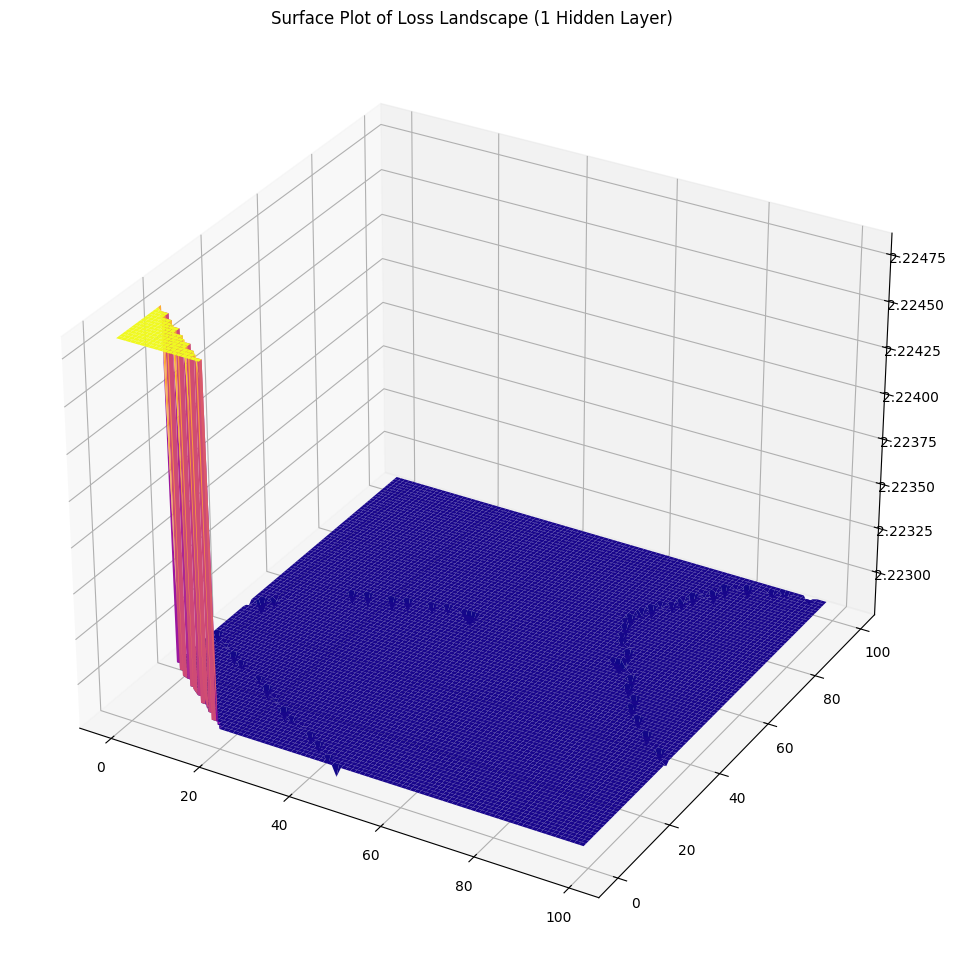

In [30]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_one_fin, rstride=1, cstride=1, cmap='plasma', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape (1 Hidden Layer)')
fig.show()

/tmp/ipykernel_5363/1773300366.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


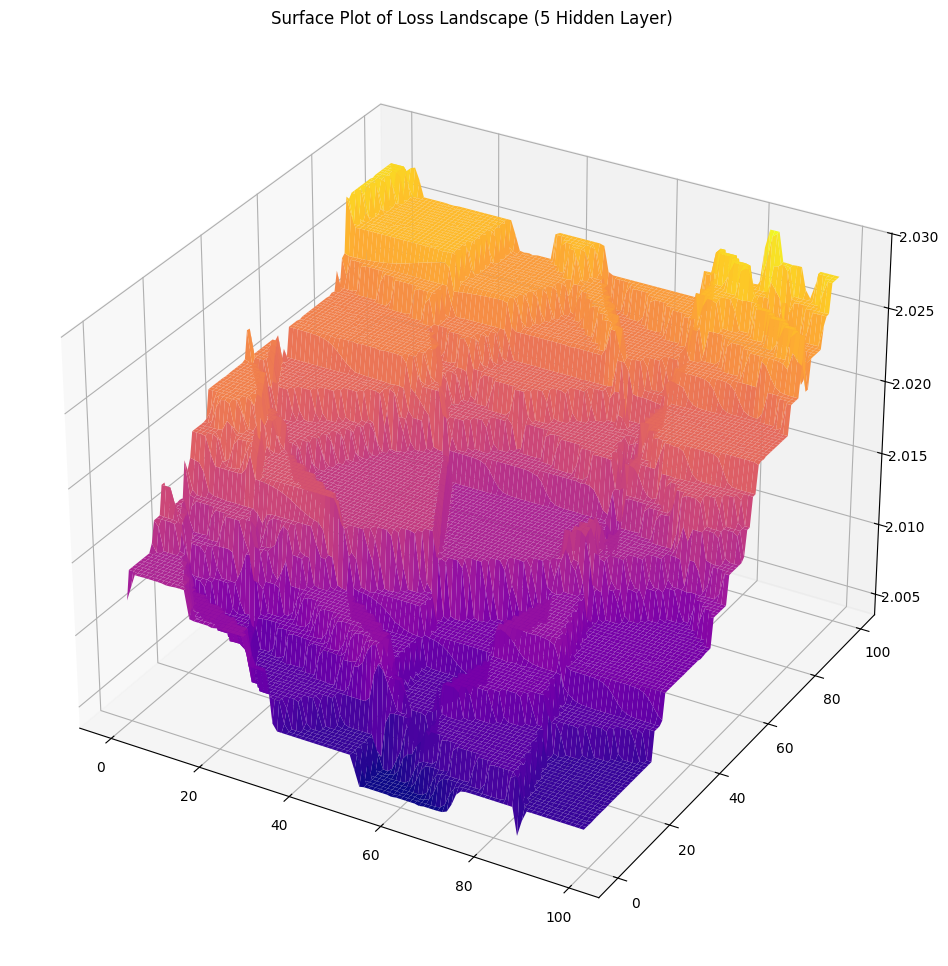

In [31]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_five_fin, rstride=1, cstride=1, cmap='plasma', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape (5 Hidden Layer)')
fig.show()

/tmp/ipykernel_5363/3007201407.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


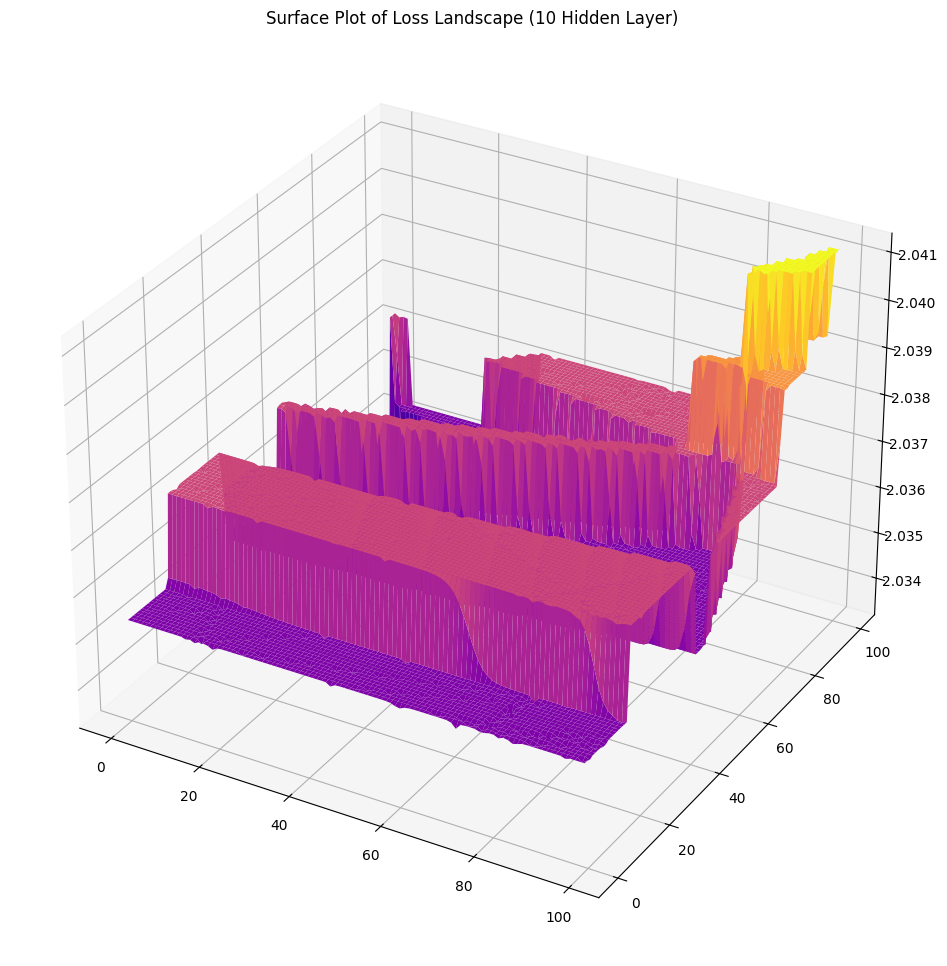

In [32]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_ten_fin, rstride=1, cstride=1, cmap='plasma', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape (10 Hidden Layer)')
fig.show()